In [ ]:
!pip install transformers
!pip install sacremoses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895241 sha256=8287f5509aefd384fb8cfcc29691498d7a8af920e1d2df7f8189990decdabbf7
  Stored in directory: /root/.cache/pip/wheels/00/24/97/a2ea5324f36bc626e1ea0267f33db6aa80d157ee977e9e42fb
Successfully built sacremoses


In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import random
import os
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import torch
from transformers import HerbertTokenizer, RobertaModel, AutoTokenizer, BertModel

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
os.mkdir("figs")

In [ ]:
def get_confusion_matrix(model, X_test, y_test, model_name, data_type, classes):

  cls =[]
  for k in classes.keys():
    cls.append(k)

  y_pred = model.predict(X_test)
  pred_labels=[]
  for idx in range(len(y_pred)):
    pred_label = np.argmax(y_pred[idx])
    pred_labels.append(pred_label)

  true_labels = y_test
  score = accuracy_score(true_labels, pred_labels)
  cm = confusion_matrix(true_labels, pred_labels, normalize='true')

  #disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  #disp.plot()
  #disp.ax_.set_title("Model: {} | Data type: {} |  Acc: {}".format(model_name, data_type, score))

  #if classes is not None:
      #tick_marks = np.arange(len(cls))
      #plt.xticks(tick_marks, cls, rotation=45)
      #plt.yticks(tick_marks, cls, rotation=50)

  #plt.gcf().set_size_inches(10, 10)
  #plt.savefig('/content/figs/{}_{}.png'.format(model_name, data_type), dpi=200)
  #files.download('/content/figs/{}_{}.png'.format(model_name, data_type))

  return score, cm

In [ ]:
def draw_learning_curve(history, data_type, key='accuracy'):

  fig, ax = plt.subplots(1, 2, figsize=(12,6))
  ax[0].plot(history.history[key])
  ax[0].plot(history.history['val_'+ key] )
  ax[0].set_ylabel(key.title())
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['train', 'val'])

  ax[1].plot(history.history['loss'])
  ax[1].plot(history.history['val_loss'] )
 # ax[1].set_ylim([0,1])
  ax[1].set_ylabel('loss'.title())
  ax[1].set_xlabel('Epoch')
  ax[1].legend(['train', 'val'])
  fig.suptitle('Learning curve | Data type: {}'.format(data_type))
  plt.show()
  #fig.savefig('/content/figs/learning_curve_{}.png'.format(data_type))
  #files.download('/content/figs/learning_curve_{}.png'.format(data_type))


In [ ]:
def get_data_set(labels, df):
  idxs = []
  for label in labels:
    idxs_for_label, = np.where(df['Label'] == label)
    for idx in idxs_for_label:
      idxs.append(idx)

  new_df = df.iloc[idxs]
  new_df = new_df.sample(frac = 1).reset_index(drop=True)
  return new_df

In [ ]:
def print_classes(df):
  authors = {}
  y = df['Label']
  if len(df['Label'].unique()) < 8:
    y = df ['Label'].factorize()[0]
  num_classes = len(df['Label'].unique())
  for label in range(0, num_classes):
    i, = np.where(y == label)
    authors['{}'.format(df['Author-short'][i[0]])] = label

  return authors

In [ ]:
def make_embedding(df, model):

  X_stack = []
  model_name, tokenizer, model = model
  embedded = {}
  tokens = {}
  num_idxs = df.shape[0]
  for idx in tqdm(range(0,num_idxs)):
    single_poem_input = df['Text'][idx]
    inputs = tokenizer.batch_encode_plus([single_poem_input], max_length = 512, padding="longest", add_special_tokens=True, return_tensors="pt",)
    single_poem_output = model(**inputs)
    X_single_poem = single_poem_output[0][:,0,:].detach().numpy()
    X_stack.append(X_single_poem[0])

    embedded[idx] = X_single_poem[0], df['Label'][idx]

  df_embedded = pd.DataFrame.from_dict(embedded,  orient='index', columns=['embedding', 'label'])

  return df_embedded

In [ ]:
def normalize_data(X):

  X_normalized = np.zeros((X.shape[0],X.shape[1]))

  for idx in range(0,X.shape[0]):
    X_normalized[idx,:] = (X[idx,:] - np.mean(X[idx,:]))/ np.std(X[idx,:])

  return X_normalized

In [ ]:
def get_X_y(df, normalization=True):

  X = np.stack(df['embedding'])
  y = df['Label']
  if(normalization==True):
    X = normalize_data(X)

  #jeśli jest mniej niż 8 klas:
  if len(df['Label'].unique()) < 8:
    y = df ['Label'].factorize()[0]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

  print(X.shape)

  return X, y, X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
def get_X_y_train(df, normalization=True):

  X = np.stack(df['embedding'])
  y = df['Label']
  if(normalization==True):
    X = normalize_data(X)

  #jeśli jest mniej niż 8 klas:
  if len(df['Label'].unique()) < 8:
    y = df ['Label'].factorize()[0]

  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)


  print(X.shape)

  return X, y, X_train, X_val, y_train, y_val

In [ ]:
def get_X_y_test(df, normalization=True):
  X = np.stack(df['embedding'])
  y = df['Label']
  if(normalization == True):
    X = normalize_data(X)

  #jeśli jest mniej niż 8 klas:
  if len(df['Label'].unique()) < 8:
    y = df ['Label'].factorize()[0]

  return X, y

In [ ]:
import string

def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct

In [ ]:
def swap_words(df):

  dict_new_text = {}

  for idx in tqdm(range(0,len(df))):
    text_split = df['Text'][idx].split()
    to_swap_list = []
    #n_pairs = int((len(text_split) * fraction)/2)
   # if(n_pairs==0):
    n_pairs = 1

    for i in range(0,n_pairs):
      idx_to_swap_1 = random.randrange(0, len(text_split))
      idx_to_swap_2 = random.randrange(0, len(text_split))
      if(idx_to_swap_1 != idx_to_swap_2):
        word_to_swap_1 = text_split[idx_to_swap_1]
        word_to_swap_2 = text_split[idx_to_swap_2]
        text_split[idx_to_swap_1] = word_to_swap_2
        text_split[idx_to_swap_2] = word_to_swap_1

    new_text = ' '.join(text_split)

    dict_new_text[idx] = new_text, df['Label'][idx], df['Author-short'][idx]

  df_swap_words = pd.DataFrame.from_dict(dict_new_text, orient='index', columns=['Text', 'Label', 'Author-short'])
  return df_swap_words

# dzielenie każdego wiersza na fragmenty o długości 60 słów
def cut_with_window(df, window_size, step_size):

  dict_new_text = {}

  for idx in tqdm(range(0,len(df))):
    text_split = df['Text'][idx].split()
    x = 0
    y = window_size
    i = 0
    while x < len(text_split):
      #y = x + window_size
      new_text_arr = text_split[x:y]
      new_text = ' '.join(new_text_arr)

      i = i + 1
      x = x + step_size
      y = min(x + window_size, len(text_split)-1)
      dict_new_text[idx, i] = new_text, df['Label'][idx], df['Author-short'][idx]

  df_cut = pd.DataFrame.from_dict(dict_new_text,  orient='index', columns=['Text', 'Label', 'Author-short'])
  return df_cut

# usuwanie kielku randomowo wybranych słów z orginalnego wiersza
def remove_words(df, fraction):

  dict_new_text = {}

  for idx in tqdm(range(0,len(df))):
    text_split = df['Text'][idx].split()
    f = int(fraction * len(text_split))
    if(f==0):
      f = 1
    to_remove_list = []

    for i in range(0,f):
      to_remove = random.randrange(0, len(text_split))
      to_remove_list.append(to_remove)

    for word_idx in to_remove_list:
      text_split[word_idx] = ' '

    new_text = ' '.join(text_split)

    dict_new_text[idx] = new_text, df['Label'][idx], df['Author-short'][idx]

  df_remove = pd.DataFrame.from_dict(dict_new_text,  orient='index', columns=['Text', 'Label', 'Author-short'])
  return df_remove


# podział wiersza na pół
def cut_in_half(df):

  new_dict_1 = {}
  new_dict_2 = {}

  for idx in tqdm(range(0,len(df))):

    text_split = df['Text'][idx].split()
    x = int(len(text_split)/2)
    new_text_arr_1 = text_split[:x]
    new_text_arr_2 = text_split[x:]
    new_text_1 = " ".join(new_text_arr_1)
    new_text_2 = " ".join(new_text_arr_2)

    new_dict_1[idx] = new_text_1, df['Label'][idx], df['Author-short'][idx]
    new_dict_2[idx] = new_text_2, df['Label'][idx], df['Author-short'][idx]

  df_new_1 = pd.DataFrame.from_dict(new_dict_1,  orient='index', columns=['Text', 'Label', 'Author-short'])
  df_new_2 = pd.DataFrame.from_dict(new_dict_2,  orient='index', columns=['Text', 'Label', 'Author-short'])

  result = pd.concat([df_new_1, df_new_2])
  df_cut = result.reset_index(drop=True)
  df_cut
  return df_cut

#odbicie lustrzane wiersza
def flip(df):
  new_dict = {}

  for idx in tqdm(range(0,len(df))):
    text_split = df['Text'][idx].split()
    text_split.reverse()
    new_text = " ".join(text_split)

    new_dict[idx] = new_text, df['Label'][idx], df['Author-short'][idx]

  df_flip = pd.DataFrame.from_dict(new_dict,  orient='index', columns=['Text', 'Label', 'Author-short'])
  return df_flip

def cut_and_flip(df, part):
  new_dict = {}

  for idx in tqdm(range(0,len(df))):
    text_split = df['Text'][idx].split()
    x = int(len(text_split)/2)
    new_text_arr_1 = text_split[:x]
    new_text_arr_2 = text_split[x:]
    if(part==1):
      new_text_arr_1.reverse()
    if(part==2):
      new_text_arr_2.reverse()
    if(part==3):
      new_text_arr_1.reverse()
      new_text_arr_2.reverse()
    new_text_arr = new_text_arr_1 + new_text_arr_2
    new_text = " ".join(new_text_arr)

    new_dict[idx] = new_text, df['Label'][idx], df['Author-short'][idx]

  df_cut_and_flip = pd.DataFrame.from_dict(new_dict,  orient='index', columns=['Text', 'Label', 'Author-short'])
  return df_cut_and_flip


def remove_half(df):

  new_dict = {}

  for idx in tqdm(range(0,len(df))):

    text_split = df['Text'][idx].split()
    x = round(len(text_split)/2)
    new_text_arr_1 = text_split[:x]
    new_text_arr_2 = text_split[x:]
    new_text_1 = " ".join(new_text_arr_1)
    new_text_2 = " ".join(new_text_arr_2)
    part_to_remove = random.choices((0,1))
    if(part_to_remove==0):
      new_dict[idx] = new_text_1, df['Label'][idx], df['Author-short'][idx]
    else:
      new_dict[idx] = new_text_2, df['Label'][idx], df['Author-short'][idx]

  df_remove_half = pd.DataFrame.from_dict(new_dict,  orient='index', columns=['Text', 'Label', 'Author-short'])

  return df_remove_half

def remove_part(df):

  new_dict_1 = {}
  new_dict_2 = {}

  for idx in tqdm(range(0,len(df))):

    text_split = df['Text'][idx].split()
    x = round(len(text_split)/3)
    new_text_arr_1 = text_split[:x]
    new_text_arr_2 = text_split[x:2*x]
    new_text_arr_3 = text_split[2*x:]
    new_text_1 = " ".join(new_text_arr_1)
    new_text_2 = " ".join(new_text_arr_2)
    new_text_3 = " ".join(new_text_arr_3)
    part_to_remove = random.choices((0,2))
    if(part_to_remove==0):
      new_dict_1[idx] = new_text_2, df['Label'][idx], df['Author-short'][idx]
      new_dict_2[idx] = new_text_3, df['Label'][idx], df['Author-short'][idx]
    if(part_to_remove==1):
      new_dict_1[idx] = new_text_1, df['Label'][idx], df['Author-short'][idx]
      new_dict_2[idx] = new_text_3, df['Label'][idx], df['Author-short'][idx]
    else:
      new_dict_1[idx] = new_text_1, df['Label'][idx], df['Author-short'][idx]
      new_dict_2[idx] = new_text_2, df['Label'][idx], df['Author-short'][idx]



  df_new_1 = pd.DataFrame.from_dict(new_dict_1, orient='index', columns=['Text', 'Label', 'Author-short'])
  df_new_2 = pd.DataFrame.from_dict(new_dict_2, orient='index', columns=['Text', 'Label', 'Author-short'])

  result = pd.concat([df_new_1, df_new_2])
  df_remove_part = result.reset_index(drop=True)
  df_remove_part

  return df_remove_part

In [ ]:
def split_data(df_outer, split_size):
  df = df_outer.copy(deep=True)
  df_train = pd.DataFrame()
  df_test = pd.DataFrame()
  idxs_to_drop = []
  idxs_for_test = []

  labels = df["Label"].unique()
  y = df['Label']
  if len(df['Label'].unique()) < 8:
    y = df ['Label'].factorize()[0]
    labels = np.arange(0, len(df['Label'].unique()))

  for n, label in enumerate(labels):
    idxs_for_label, = np.where(y == label)
    idxs_for_test = np.random.choice(idxs_for_label, size = split_size, replace=False)

    for idx in idxs_for_test:
      df_test = df_test.append(df.iloc[idx])
      idxs_to_drop.append(idx)


  for idx in range(0, len(df)):
    if(idx not in idxs_to_drop):
      df_train = df_train.append(df.iloc[idx])

  df_train = df_train.reset_index(drop=True)
  df_test = df_test.reset_index(drop=True)

  return df_train, df_test

In [ ]:
def make_experiment(model, df, test_size, val_size, data_type, scheme, fraction, alpha, n_realizations, normalization,):

  normalize = "normalized.0"
  if(normalization==True):
    normalize = "normalized.1"
  model_name = model[0]

  n_classes = len(df['Label'].unique())
  CM = np.zeros((n_classes, n_classes, n_realizations))
  scores = []
  epochs = 125
  batch_size = 512
  train_loss_realizations = np.zeros((epochs, n_realizations))
  train_acc_realizations = np.zeros((epochs, n_realizations))
  val_loss_realizations = np.zeros((epochs, n_realizations))
  val_acc_realizations = np.zeros((epochs, n_realizations))
  for n in range(0, n_realizations):
    # podział danych na dane testowe oraz treningowe i validacyjne. Dane testowe i validacyjne poddaję embedingowi i tworzę dla nich X, y
    df_train_and_val, df_test = split_data(df, test_size)
    df_train_to_augment, df_val = split_data(df_train_and_val, val_size)

    embed_test = make_embedding(df_test, model)
    df_test = pd.concat([df_test, embed_test['embedding']], axis=1)

    embed_val = make_embedding(df_val, model)
    df_val = pd.concat([df_val, embed_val['embedding']], axis=1)

    X_test, y_test = get_X_y_test(df_test, normalization)
    X_val, y_val = get_X_y_test(df_val, normalization)

    # augmentacja danych w zbiorze treningowym
    args = [fraction, alpha]
    df_train = generate_data(model, df_train_to_augment, scheme, args)
    print('Test: {} Val: {} Train: {}'.format(df_test.shape, df_val.shape, df_train.shape))

    X_train, y_train = get_X_y_test(df_train, normalization)
    y_train = to_categorical(y_train)
    y_val = to_categorical(y_val)

    input_size = X_train.shape[1]

    model_NN = Sequential([
      Dense(input_size, input_dim=input_size, activation='relu'),
      Dense(2*input_size, activation='relu'),
      Dense(4*input_size, activation='relu'),
      Dropout(0.2),
      Dense(n_classes, activation='softmax')
    ])
    opt = keras.optimizers.Adam(learning_rate=1e-3)
    model_NN.compile(loss='categorical_crossentropy', optimizer=opt, metrics='accuracy')
    history = model_NN.fit(X_train, y_train,
            batch_size=batch_size, epochs=epochs,verbose=0,
            validation_data=(X_val, y_val))

    train_loss_realizations[:,n] = history.history['loss']
    val_loss_realizations[:,n] = history.history['val_loss']
    train_acc_realizations[:,n] = history.history['accuracy']
    val_acc_realizations[:,n] = history.history['val_accuracy']

    classes = print_classes(df_test)

    score, CM[:,:,n] = get_confusion_matrix(model_NN, X_test, y_test, 'neural_network', data_type, classes)
    scores.append(score)

# dane do uśrednionej krzywej uczenia
  val_loss_mean = np.mean(val_loss_realizations, axis=1)
  train_loss_mean = np.mean(train_loss_realizations, axis=1)
  val_acc_mean = np.mean(val_acc_realizations, axis=1)
  train_acc_mean = np.mean(train_acc_realizations, axis=1)

  val_loss_std = np.std(val_loss_realizations, axis=1)
  train_loss_std = np.std(train_loss_realizations, axis=1)
  val_acc_std = np.std(val_acc_realizations, axis=1)
  train_acc_std = np.std(train_acc_realizations, axis=1)

  dict_history = {"val_loss_mean":val_loss_mean,
                  "train_loss_mean":train_loss_mean,
                  "val_acc_mean":val_acc_mean,
                  "train_acc_mean":train_acc_mean,
                  "val_loss_std":val_loss_std,
                  "train_loss_std":train_loss_std,
                  "val_acc_std":val_acc_std,
                  "train_acc_std":train_acc_std}

# uśredniona krzywa uczenia
  fontsize = 16
  epoch_vec = np.arange(0,epochs)
  fig, ax = plt.subplots(1,2,figsize = (12, 8))
  clrs = sns.color_palette("flare")
  ax[1].set_ylim([0,2])
  ax[1].plot(epoch_vec, train_loss_mean, label = "train")
  ax[1].fill_between(epoch_vec, train_loss_mean - train_loss_std, train_loss_mean + train_loss_std, alpha = 0.3, facecolor=clrs[4] )
  ax[1].plot(val_loss_mean,  label = "val")
  ax[1].fill_between(epoch_vec, val_loss_mean - val_loss_std, val_loss_mean + val_loss_std, alpha = 0.3, facecolor=clrs[4] )

  ax[0].plot(epoch_vec, train_acc_mean,  label = "train")
  ax[0].fill_between(epoch_vec, train_acc_mean - train_acc_std, train_acc_mean + train_acc_std, alpha = 0.3, facecolor=clrs[4])
  ax[0].plot(val_acc_mean,  label = "val")
  ax[0].fill_between(epoch_vec, val_acc_mean - val_acc_std, val_acc_mean + val_acc_std, alpha = 0.3, facecolor=clrs[4] )


  ax[1].set_xlabel("Traning epoch", fontsize=fontsize)
  ax[1].set_ylabel("Loss", fontsize=fontsize)
  ax[0].set_xlabel("Traning epoch", fontsize=fontsize)
  ax[0].set_ylabel("Accuracy", fontsize=fontsize)

  ax[1].legend( fontsize = fontsize)
  ax[0].legend( fontsize = fontsize)
  fig.suptitle('Learning curve | Data type: {}'.format(data_type))

  fig.savefig('/content/figs/avgr_learning_curve_{}_{}_{}_scheme_{}_fraction_{}_alpha_{}.png'.format(model_name, data_type, normalize, scheme, fraction, alpha))
  files.download('/content/figs/avgr_learning_curve_{}_{}_{}_scheme_{}_fraction_{}_alpha_{}.png'.format(model_name, data_type, normalize, scheme, fraction, alpha))

# uśredniona macierz konfuzji
  CM_avrg = np.zeros((n_classes,n_classes))
  CM_std = np.zeros((n_classes,n_classes))
  score_avrg = np.mean(scores)

  for i in range(0,n_classes):
    for j in range(0,n_classes):
      CM_avrg[i,j] = np.mean(CM[i,j,:])
      CM_std[i,j] = np.std(CM[i,j,:])

  classes = print_classes(df)
  cls = []
  for k in classes.keys():
    cls.append(k)

  tick_marks = np.arange(len(cls))
  cms = {"Average": CM_avrg, "Std": CM_std}


  fig2, axes = plt.subplots(1, 2, figsize=(20,10), sharey='row')

  for i, (key, cm) in enumerate(cms.items()):

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title("{} | Model: Neural Network | Data type: {} | Acc: {}".format(key, data_type, round(score_avrg,2)))
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    disp.ax_.set_ylabel('')


  fig2.text(0.40, 0.1, 'Predicted label', ha='left')
  plt.subplots_adjust(wspace=0.40, hspace=0.1)

  fig2.colorbar(disp.im_, ax=axes)
  plt.show()

  plt.gcf().set_size_inches(10, 5)
  fig2.savefig('/content/figs/avrg_neural_network_{}_{}_{}_scheme_{}_fraction_{}_alpha_{}.png'.format(model_name, data_type, normalize, scheme, fraction, alpha), dpi=200)
  files.download('/content/figs/avrg_neural_network_{}_{}_{}_scheme_{}_fraction_{}_alpha_{}.png'.format(model_name, data_type, normalize, scheme, fraction, alpha))

  return score_avrg

In [ ]:
def generate_data(model, df_outer, scheme, args):

  f, alpha = args
  df = df_outer.copy(deep=True)
  if(scheme==0):
    df_new = cut_in_half(df)

  if(scheme==1):
    df_new = flip(df)

  if(scheme==2):
    df_new_1 = cut_in_half(df)
    df_new_1 = flip(df_new_1)
    df_new_2 = flip(df)
    df_new = pd.concat([df_new_1, df_new_2]).reset_index(drop=True)

  if(scheme==3):
      df_new = remove_words(df, f)

  if(scheme==4):
      df_new_1 = cut_in_half(df)
      df_new_1 = remove_words(df_new_1, f)
      df_new_2 = remove_words(df, f)
      df_new = pd.concat([df_new_1, df_new_2]).reset_index(drop=True)

  if(scheme==5):
      df_new_1 = remove_words(df, f)
      df_new_1 = flip(df_new_1)
      df_new_2 = remove_words(df, f)
      df_new = pd.concat([df_new_1, df_new_2]).reset_index(drop=True)

  if(scheme==6):
      df_new_1 = cut_in_half(df)
      df_new_1 = flip(df_new_1)
      df_new_2 = remove_words(df, f)
      df_new_2 = flip(df_new_2)
      df_new_3 = remove_words(df, f)
      df_new = pd.concat([df_new_1, df_new_2, df_new_3]).reset_index(drop=True)

  if(scheme==7):

      df_new_1 = cut_in_half(df)
      df_new_1 = remove_words(df_new_1, f)
      df_new_2 = cut_in_half(df)
      df_new_2 = remove_words(df_new_2, f)
      df_new_2 = flip(df_new_2)
      df_new_3 = remove_words(df, f)
      df_new_3 = flip(df_new_3)
      df_new_4 = remove_words(df, f)
      df_new = pd.concat([df_new_1, df_new_2, df_new_3, df_new_4]).reset_index(drop=True)

  if(scheme==8):

      df_new_1 = cut_and_flip(df,1)
      df_new_2 = cut_and_flip(df,2)
      df_new_3 = cut_and_flip(df,3)
      df_new_4 = remove_words(df,f)
      df_new_4 = flip(df_new_4)
      df_new_5 = remove_words(df,f)
      df_new = pd.concat([df_new_1, df_new_2, df_new_3, df_new_4, df_new_5]).reset_index(drop=True)

  if(scheme==9):
      df_new_1 = cut_and_flip(df,1)
      df_new_1 = remove_words(df_new_1,f)
      df_new_2 = cut_and_flip(df,2)
      df_new_2 = remove_words(df_new_2,f)
      df_new_3 = cut_and_flip(df,3)
      df_new_3 =remove_words(df_new_3,f)
      df_new_4 = remove_words(df,f)
      df_new_4 = flip(df_new_4)
      df_new_5 = remove_words(df,f)
      df_new = pd.concat([df_new_1, df_new_2, df_new_3, df_new_4, df_new_5]).reset_index(drop=True)

  if(scheme==10):
      df_new_1 = df
      df_new_aug = df.sample(round(len(df)*alpha)).reset_index(drop=True)
      df_new_2 = remove_words(df_new_aug, f)
      df_new_3 = flip(df_new_aug)
      df_new_4 = cut_in_half(df_new_aug)
      df_new = pd.concat([df_new_1, df_new_2, df_new_3, df_new_4]).reset_index(drop=True)


  if(scheme==11):
      df_new_1 = df
      df_new_aug = df.sample(frac=alpha,axis=0).reset_index(drop=True)
      x = int(len(df_new_aug)/4)
      df_new_aug_1 = df_new_aug.iloc[:x]
      df_new_aug_2 = df_new_aug.iloc[x:2*x]
      df_new_aug_3 = df_new_aug.iloc[2*x:3*x]
      df_new_aug_4 = df_new_aug.iloc[3*x:]
      df_new_2 = remove_words(df_new_aug_1.reset_index(drop=True), f)
      df_new_3 = flip(df_new_aug_2.reset_index(drop=True))
      df_new_4 = swap_words(df_new_aug_3.reset_index(drop=True))
      df_new_5 = cut_in_half(df_new_aug_4.reset_index(drop=True))
      df_new = pd.concat([df_new_1, df_new_2, df_new_3, df_new_4, df_new_5]).reset_index(drop=True)
      #df_new = pd.concat([df_new_1, df_new_2, df_new_3, df_new_5]).reset_index(drop=True)

  if(scheme==12):
      df_new_1 = df
      df_new_aug = df.sample(frac=alpha,axis=0).reset_index(drop=True)
      df_new_2 = remove_words(df_new_aug.sample(frac = 0.5, axis=0).reset_index(drop=True), f)
      df_new_3 = flip(df_new_aug.sample(frac = 0.5, axis=0).reset_index(drop=True))
      #df_new_4 = swap_words(df_new_aug.sample(frac = 0.33, axis=0).reset_index(drop=True))
      df_new = pd.concat([df_new_1, df_new_2, df_new_3]).reset_index(drop=True)


  if(scheme==13):
      df_new_1 = df

      df_new_aug = df.sample(frac=alpha,axis=0).reset_index(drop=True)
      df_new_2 = remove_words(df_new_aug.sample(frac = 0.5, axis=0).reset_index(drop=True), f)
      #df_new_3 = flip(df_new_aug.sample(frac = 0.33, axis=0).reset_index(drop=True))
      df_new_4 = swap_words(df_new_aug.sample(frac = 0.5, axis=0).reset_index(drop=True))
      df_new = pd.concat([df_new_1, df_new_2,  df_new_4]).reset_index(drop=True)



  if(scheme==14):
      df_new_1 = df

      df_new_aug = df.sample(frac=alpha,axis=0).reset_index(drop=True)
     # df_new_2 = remove_words(df_new_aug.sample(frac = 0.33, axis=0).reset_index(drop=True), f)
      df_new_3 = flip(df_new_aug.sample(frac = 0.5, axis=0).reset_index(drop=True))
      df_new_4 = swap_words(df_new_aug.sample(frac = 0.5, axis=0).reset_index(drop=True))
      df_new = pd.concat([df_new_1, df_new_3, df_new_4]).reset_index(drop=True)




  df_embed = make_embedding(df_new, model)
  df_new = pd.concat([df_new, df_embed["embedding"]], axis=1)
  df_new = df_new.sample(frac = 1).reset_index(drop=True)

  return df_new

In [ ]:
herbert_large = ["Herbert-large", HerbertTokenizer.from_pretrained("allegro/herbert-large-cased"), RobertaModel.from_pretrained("allegro/herbert-large-cased")]
herbert_base = ["Herbert-base", HerbertTokenizer.from_pretrained("allegro/herbert-base-cased"), RobertaModel.from_pretrained("allegro/herbert-base-cased")]
herbert_klej = ["Herbert-klej", HerbertTokenizer.from_pretrained("allegro/herbert-klej-cased-tokenizer-v1"), RobertaModel.from_pretrained("allegro/herbert-klej-cased-v1")]

You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at allegro/herbert-large-cased were not used when initializing RobertaModel: ['bert.encoder.layer.15.output.dense.weight', 'bert.encoder.layer.3.attention.self.value.bias', 'bert.encoder.layer.10.output.dense.weight', 'bert.encoder.layer.10.attention.output.dense.weight', 'bert.encoder.layer.12.attention.self.value.weight', 'bert.encoder.layer.9.attention.self.query.weight', 'bert.encoder.layer.20.attention.self.value.bias', 'bert.encoder.layer.10.attention.self.query.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.15.attention.self.key.weight', 'bert.encoder.layer.16.output.dense.bias', 'bert.encoder.layer.19.attention.output.dense.bias', 'bert.encoder.layer.12.output.dense.bias', 'bert.encoder.layer.13.attention.self.query.bias', 'bert.encoder.layer.20.output.dense.bias', 'bert.encoder.layer.17.attention.self.value.weight', 'bert.encoder.layer.11.attention.self.value.bias', 'bert.encoder.layer.17.attention.output.dense.b

You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing RobertaModel: ['bert.encoder.layer.7.attention.self.key.bias', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.3.attention.self.value.bias', 'bert.encoder.layer.7.attention.self.query.weight', 'bert.encoder.layer.10.output.dense.weight', 'bert.encoder.layer.6.attention.output.dense.weight', 'bert.encoder.layer.7.output.dense.bias', 'bert.encoder.layer.10.attention.output.dense.weight', 'bert.encoder.layer.11.attention.output.dense.bias', 'bert.encoder.layer.9.attention.self.query.weight', 'bert.encoder.layer.8.attention.self.query.bias', 'bert.encoder.layer.8.attention.self.value.weight', 'bert.encoder.layer.10.attention.self.query.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.2.output.dense.weight', 'cls.sso.sso_relationship.weight', 'bert.encoder.layer.1.intermediate.dense.weight', 'bert.encoder.layer.6.attention.self.value.weight', 'bert.encoder.layer

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLMTokenizer'. 
The class this function is called from is 'HerbertTokenizer'.


In [ ]:
df_raw = pd.read_csv('/content/wiersze_do_BERT_Herbert_Miłosz.csv', ";")
df_raw .columns

<ipython-input-19-856413025014>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df_raw = pd.read_csv('/content/wiersze_do_BERT_Herbert_Miłosz.csv', ";")


Index(['Author', 'Author-short', 'Title', 'Text', 'From', 'Note', 'Words',
       'Label', 'Gender', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11'],
      dtype='object')

In [ ]:
df_raw  = df_raw.drop(columns = ['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11'])
df_raw.shape

(450, 9)

In [ ]:
df_raw.iloc[400:]

In [ ]:
df_raw = df_raw.drop(df_raw.index[400:])
df_raw

Author   Author-short  \
0    Jan Kochanowksi  J. Kochanowki   
1    Jan Kochanowksi  J. Kochanowki   
2    Jan Kochanowksi  J. Kochanowki   
3    Jan Kochanowksi  J. Kochanowki   
4    Jan Kochanowksi  J. Kochanowki   
..               ...            ...   
395       Ewa Lipska      E. Lipska   
396       Ewa Lipska      E. Lipska   
397       Ewa Lipska      E. Lipska   
398       Ewa Lipska      E. Lipska   
399       Ewa Lipska      E. Lipska   

                                                 Title  \
0                                            Pieśń III   
1                                             Pieśń IV   
2                                              Pieśń V   
3                                             Pieśń VI   
4                                             Pieśń IX   
..                                                 ...   
395                          Wielki Odkrywco Wyobraźni   
396  Wyznanie mężczyzny od którego kobieta odchodzi...   
397                                       Z listu (II)   
398                         Wolny przekład z Szekspira   
399                                                 My   

                                                  Text          From  Note  \
0    Nie wierz Fortunie, co siedzisz wysoko; Miej n...  Księgi wróte   NaN   
1    W twardej kamiennej wieży i za troistemi Drzwi...  Księgi wróte   NaN   
2    Wieczna sromota i nienagrodzona Szkoda, Polaku...  Księgi wróte   NaN   
3    Królewno lutnie złotej i rymów pociesznych, Oc...  Księgi wróte   NaN   
4    Nie porzucaj nadzieje, Jakoć sie kolwiek dziej...  Księgi wróte   NaN   
..                                                 ...           ...   ...   
395  Wielki Odkrywco Wyobraźni na rybiookich wspart...           NaN   NaN   
396  Odchodzisz ode mnie jak lato. I powracasz do m...           NaN   NaN   
397  I jak tu popełnić samobójstwo droga pani kiedy...           NaN   NaN   
398  W oczy mi patrzysz wciąż tak samo jak w tysiąc...           NaN   NaN   
399  My - rocznik powojenny otwarty na oścież- w pe...           NaN   NaN   

     Words  Label  Gender  
0    147.0    0.0     0.0  
1    250.0    0.0     0.0  
2    250.0    0.0     0.0  
3    109.0    0.0     0.0  
4    143.0    0.0     0.0  
..     ...    ...     ...  
395  106.0    7.0     1.0  
396  109.0    7.0     1.0  
397   63.0    7.0     1.0  
398  143.0    7.0     1.0  
399  215.0    7.0     1.0  

[400 rows x 9 columns]

In [ ]:
df_women = df_raw[200:].reset_index(drop=True)
df_men = df_raw[:200].reset_index(drop=True)
df_women = df_women.sample(frac = 1).reset_index(drop=True)
df_men = df_men.sample(frac = 1).reset_index(drop=True)

In [ ]:
df_orginal = pd.DataFrame
df_orginal = pd.concat([df_raw["Text"],df_raw["Label"],df_raw["Author-short"]], axis=1)
df_orginal = df_orginal.sample(frac = 1).reset_index(drop=True)
df_orginal

Text  Label     Author-short
0    Czerwona chmura pyłu wołała tamten pożar – zac...    3.0       Z. Herbert
1    Żonie Nie stój u ciemnych świata wód, gdzie sn...    1.0  K. K. Baczyński
2    Stateczny umysł pamiętaj zachować, Jesli cię p...    0.0    J. Kochanowki
3    Deszczu srebrne gałązki rosną jak gotyckich kr...    1.0  K. K. Baczyński
4    Byś wszystko złoto posiadł, które — powiadają ...    0.0    J. Kochanowki
..                                                 ...    ...              ...
395  1 Mazowsze. Piasek, Wisła i las. Mazowsze moje...    1.0  K. K. Baczyński
396  Nie porzucaj nadzieje, Jakoć sie kolwiek dziej...    0.0    J. Kochanowki
397  jeszcze nie wspominałam o miłości miłość tak -...    5.0  H. Poświatowska
398  mała malutka nie odchodź świat cztery strony p...    5.0  H. Poświatowska
399  Schizofrenik z pietyzmem rozdwajał na piętrze ...    7.0        E. Lipska

[400 rows x 3 columns]

<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Test: (64, 4) Val: (32, 4) Train: (304, 4)
2/2 [==============================] - 0s 6ms/step


<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Test: (64, 4) Val: (32, 4) Train: (304, 4)
2/2 [==============================] - 0s 6ms/step


<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Test: (64, 4) Val: (32, 4) Train: (304, 4)
2/2 [==============================] - 0s 7ms/step


<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Test: (64, 4) Val: (32, 4) Train: (304, 4)
2/2 [==============================] - 0s 6ms/step


<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Test: (64, 4) Val: (32, 4) Train: (304, 4)
2/2 [==============================] - 0s 6ms/step


<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Test: (64, 4) Val: (32, 4) Train: (304, 4)
2/2 [==============================] - 0s 6ms/step


<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Test: (64, 4) Val: (32, 4) Train: (304, 4)
2/2 [==============================] - 0s 6ms/step


<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Test: (64, 4) Val: (32, 4) Train: (304, 4)
2/2 [==============================] - 0s 5ms/step


<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Test: (64, 4) Val: (32, 4) Train: (304, 4)
2/2 [==============================] - 0s 5ms/step


<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Test: (64, 4) Val: (32, 4) Train: (304, 4)
2/2 [==============================] - 0s 5ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

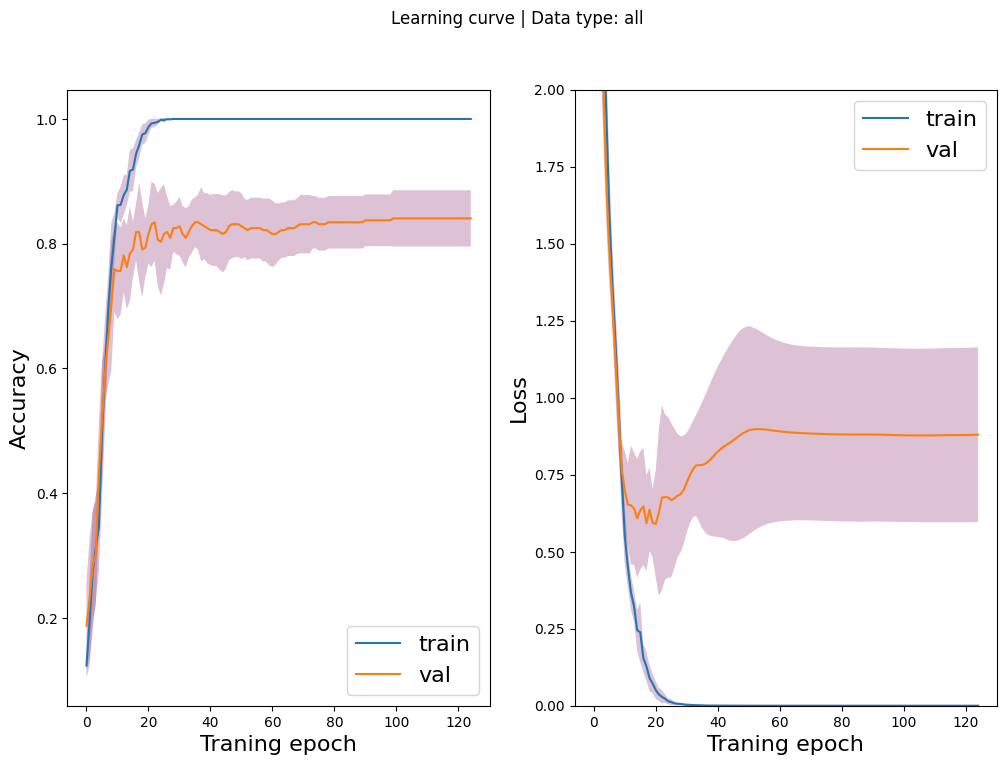

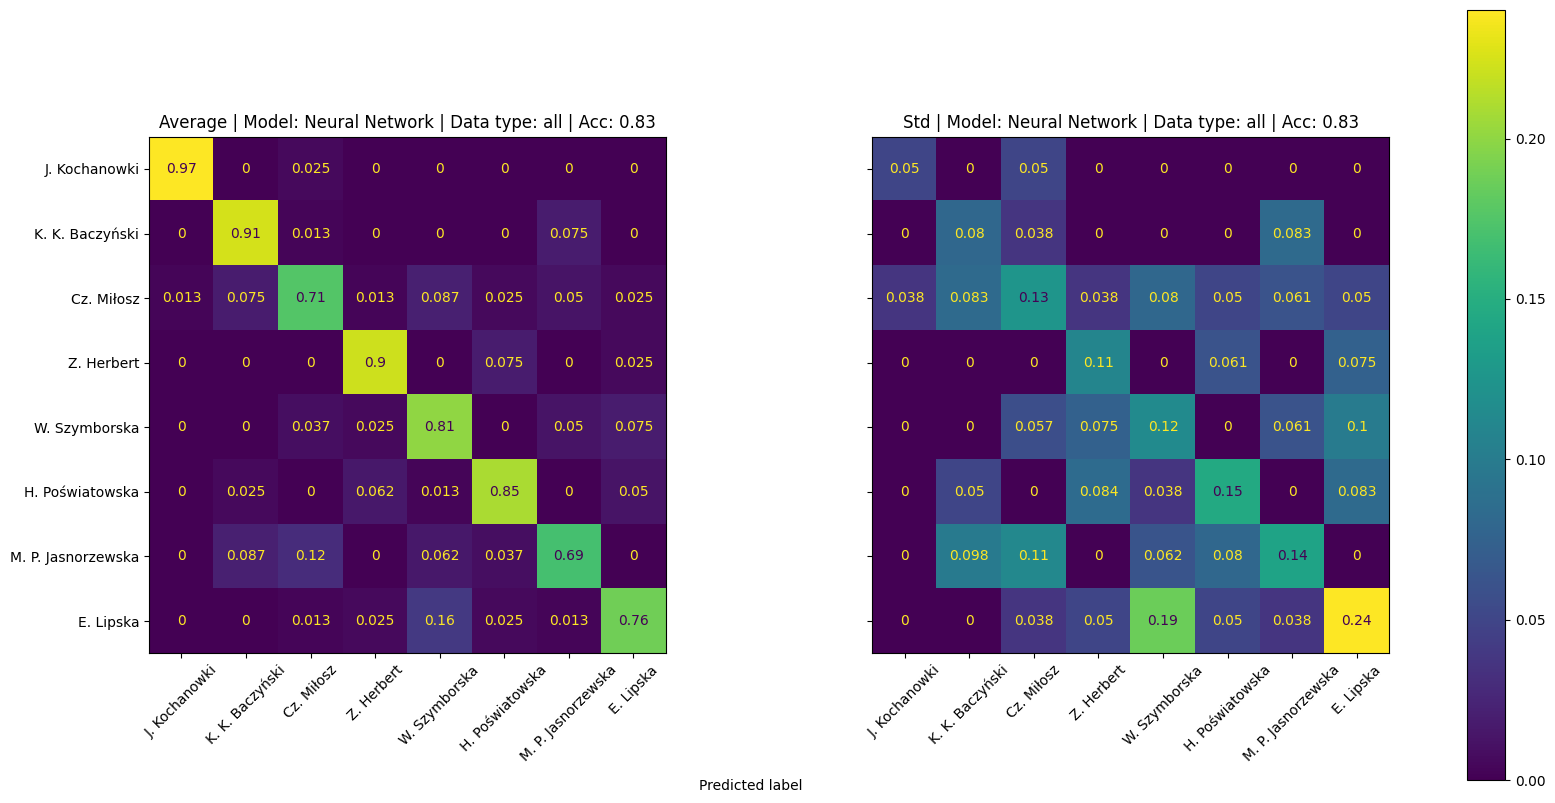

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Scheme: 11 | Fraction: 0.1 | Score: 0.8265625 | Alpha: 0.0
Acc matrix: 
[[0.8265625 0.        0.       ]]


<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Test: (64, 4) Val: (32, 4) Train: (381, 4)
2/2 [==============================] - 0s 5ms/step


<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Test: (64, 4) Val: (32, 4) Train: (381, 4)
2/2 [==============================] - 0s 5ms/step


<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Test: (64, 4) Val: (32, 4) Train: (381, 4)
2/2 [==============================] - 0s 5ms/step


<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Test: (64, 4) Val: (32, 4) Train: (381, 4)
2/2 [==============================] - 0s 6ms/step


<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Test: (64, 4) Val: (32, 4) Train: (381, 4)
2/2 [==============================] - 0s 6ms/step


<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Test: (64, 4) Val: (32, 4) Train: (381, 4)
2/2 [==============================] - 0s 6ms/step


<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Test: (64, 4) Val: (32, 4) Train: (381, 4)
2/2 [==============================] - 0s 6ms/step


<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Test: (64, 4) Val: (32, 4) Train: (381, 4)
2/2 [==============================] - 0s 6ms/step


<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Test: (64, 4) Val: (32, 4) Train: (381, 4)
2/2 [==============================] - 0s 5ms/step


<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Test: (64, 4) Val: (32, 4) Train: (381, 4)
2/2 [==============================] - 0s 6ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1000x500 with 0 Axes>

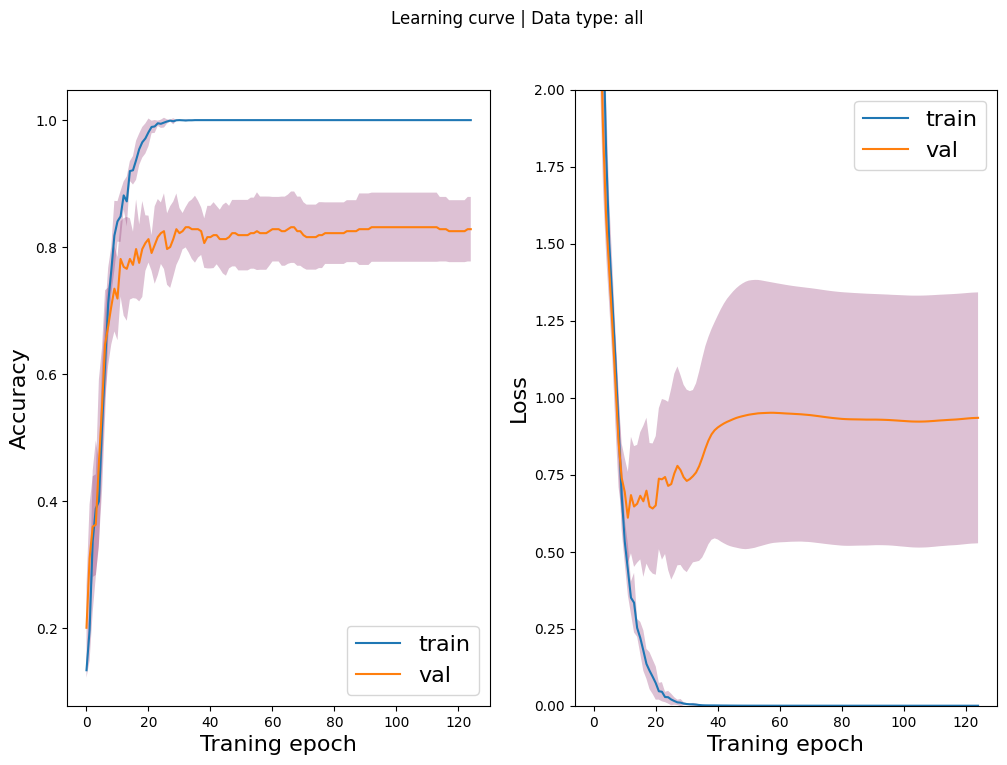

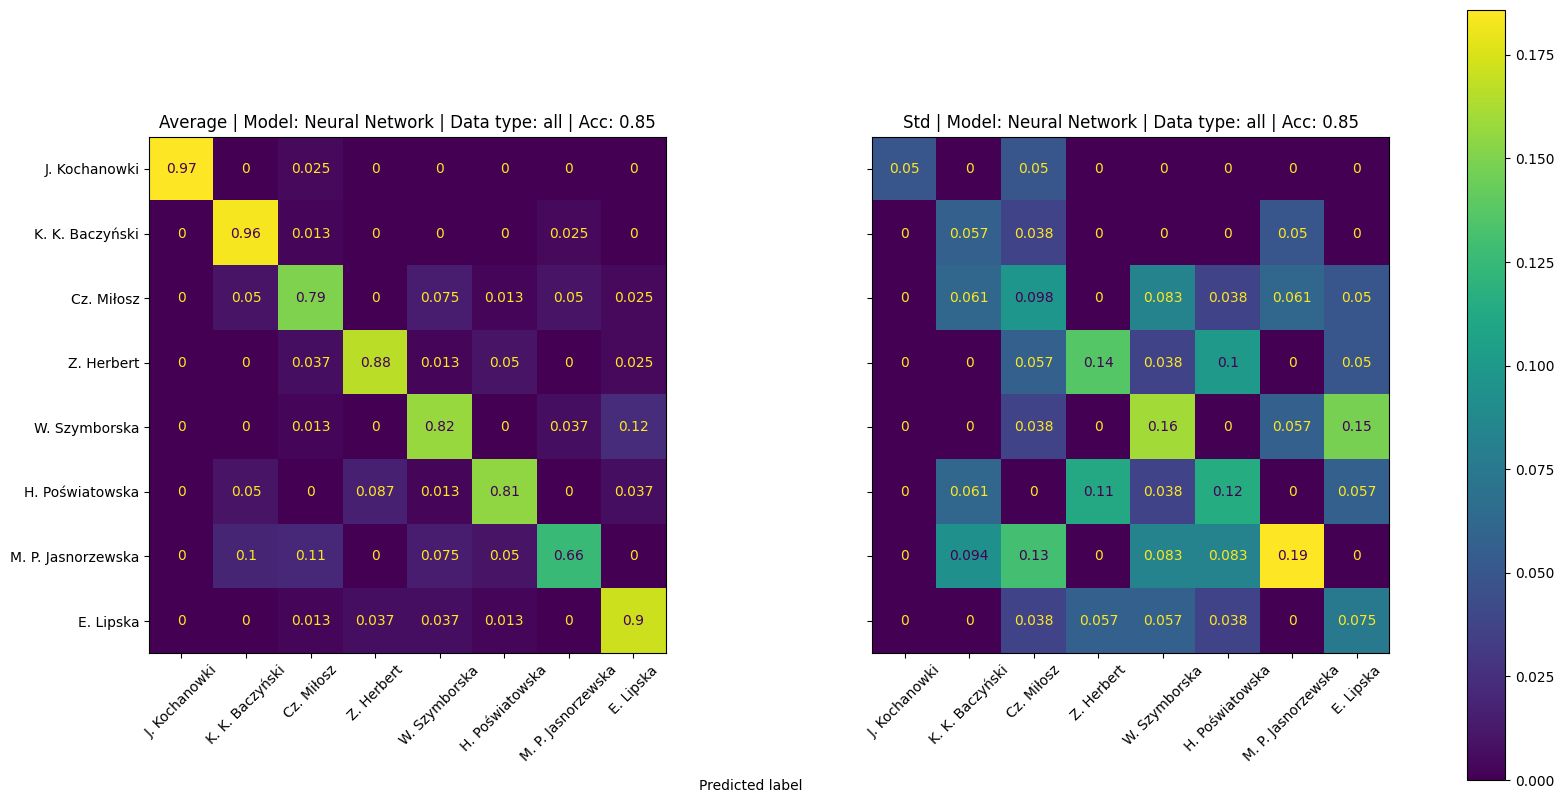

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Scheme: 11 | Fraction: 0.1 | Score: 0.85 | Alpha: 0.2
Acc matrix: 
[[0.8265625 0.85      0.       ]]


<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Test: (64, 4) Val: (32, 4) Train: (494, 4)
2/2 [==============================] - 0s 5ms/step


<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Test: (64, 4) Val: (32, 4) Train: (494, 4)
2/2 [==============================] - 0s 5ms/step


<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Test: (64, 4) Val: (32, 4) Train: (494, 4)
2/2 [==============================] - 0s 5ms/step


<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Test: (64, 4) Val: (32, 4) Train: (494, 4)
2/2 [==============================] - 0s 6ms/step


<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Test: (64, 4) Val: (32, 4) Train: (494, 4)
2/2 [==============================] - 0s 6ms/step


<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Test: (64, 4) Val: (32, 4) Train: (494, 4)
2/2 [==============================] - 0s 6ms/step


<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Test: (64, 4) Val: (32, 4) Train: (494, 4)
2/2 [==============================] - 0s 6ms/step


<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Test: (64, 4) Val: (32, 4) Train: (494, 4)
2/2 [==============================] - 0s 6ms/step


<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Test: (64, 4) Val: (32, 4) Train: (494, 4)
2/2 [==============================] - 0s 7ms/step


<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df.iloc[idx])
<ipython-input-27-6f7fdd194ee6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

Test: (64, 4) Val: (32, 4) Train: (494, 4)
2/2 [==============================] - 0s 6ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1000x500 with 0 Axes>

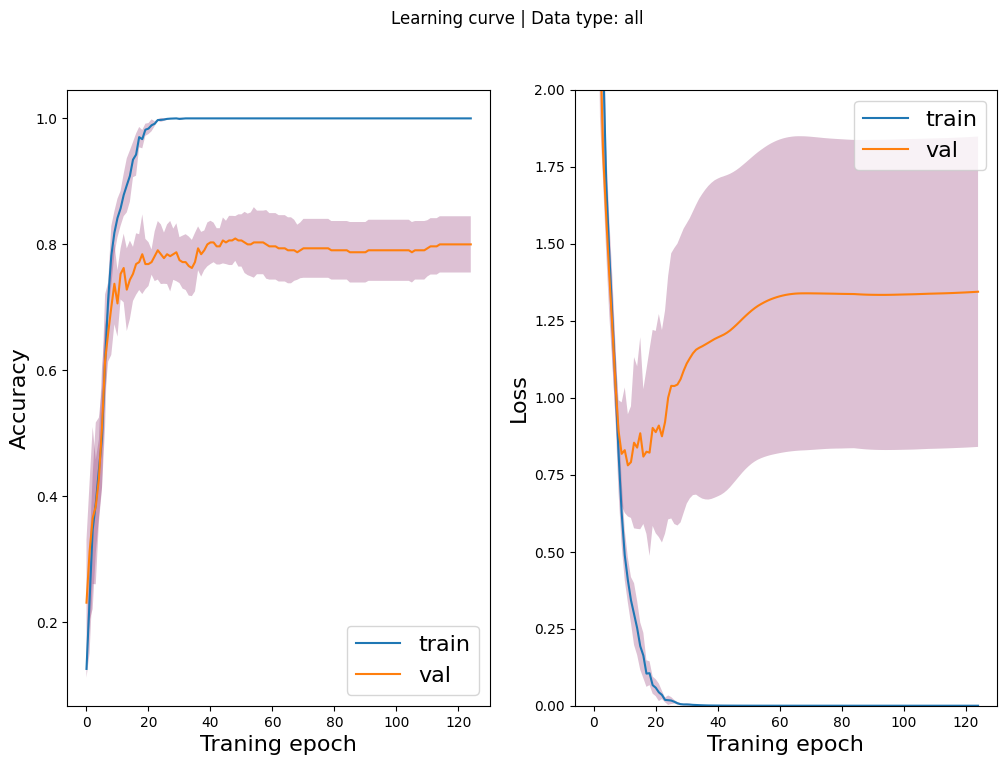

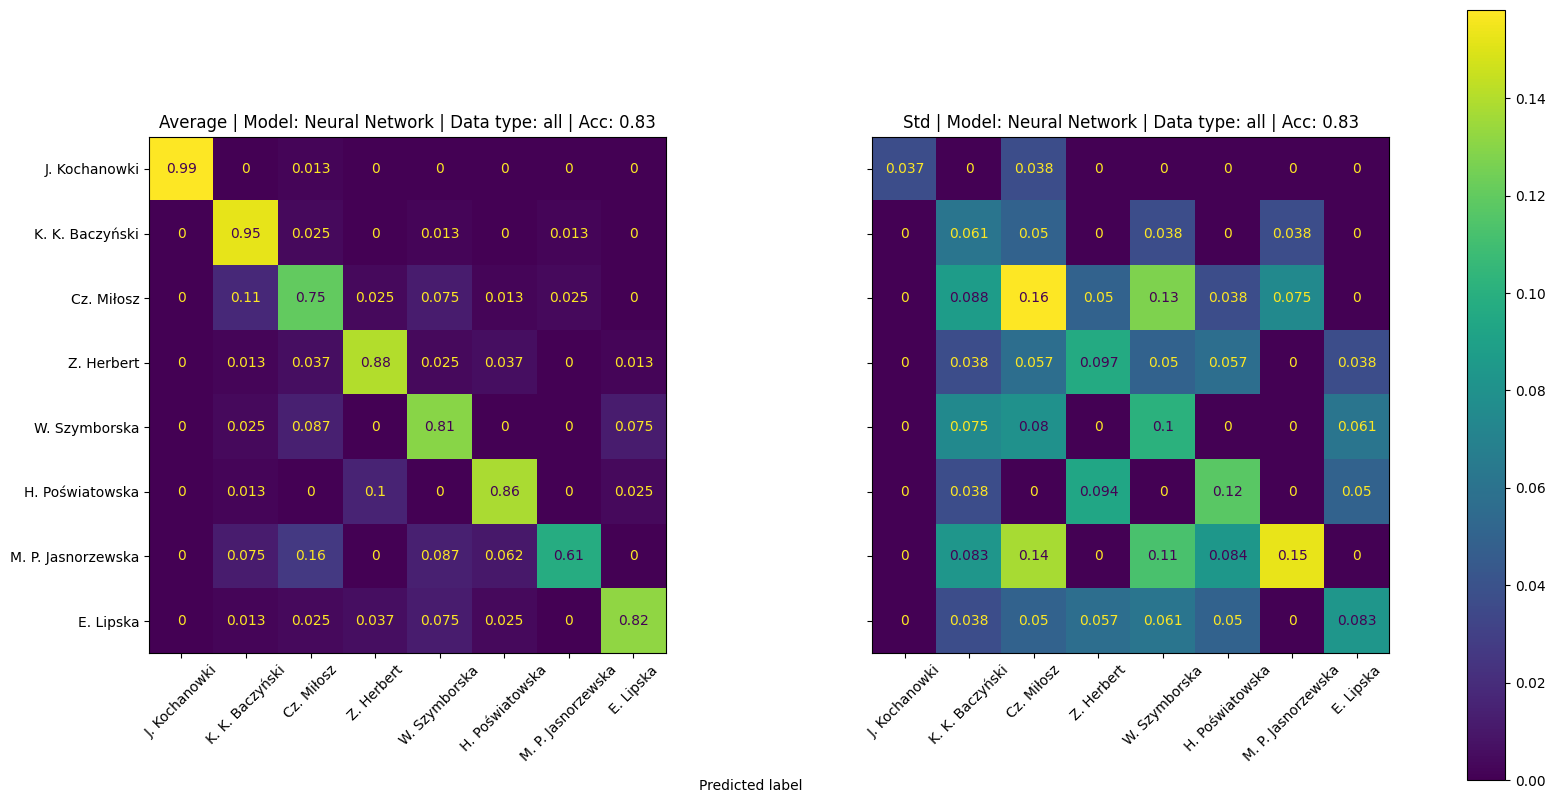

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Scheme: 11 | Fraction: 0.1 | Score: 0.834375 | Alpha: 0.5
Acc matrix: 
[[0.8265625 0.85      0.834375 ]]


<Figure size 1000x500 with 0 Axes>

In [ ]:
df = df_orginal
model = herbert_klej
data_type = 'all'

n_realizations  = 10
test_size       = 8    # number of samples per class for testing. Maximum: 50
val_size        = 4     # number of samples per class for validating. Maximum: 50

fraction_vec = np.array([0.1])
scheme_vec  = np.array([11])
alpha_vec   = np.array([0, 0.2, 0.5])

accuracy_vs_scheme_vs_fraction = np.zeros((scheme_vec.shape[0], alpha_vec.shape[0]))
dict_scores_all = []
for idx_scheme, scheme in enumerate(scheme_vec):
  for idx_alpha, alpha in enumerate(alpha_vec):
    for idx_fraction, fraction in enumerate(fraction_vec):
      score = make_experiment(model, df, test_size, val_size, data_type, scheme, fraction, alpha, n_realizations, normalization=True)
      dict_scores = {"scheme"     : scheme,
                     "fraction"   : fraction,
                     "alpha"      : alpha,
                     "score"      : score
                    }
      dict_scores_all.append(dict_scores)
      accuracy_vs_scheme_vs_fraction[idx_scheme, idx_alpha] = score
      print("Scheme: {} | Fraction: {} | Score: {} | Alpha: {}".format(scheme, fraction, score, alpha))

    print("Acc matrix: ")
    print(accuracy_vs_scheme_vs_fraction)

df_scores_all = pd.DataFrame(dict_scores_all)

In [ ]:
accuracy_vs_scheme_vs_fraction

array([[0.72625   , 0.70770833, 0.70041667],
       [0.84375   , 0.7995    , 0.8105    ],
       [0.82575   , 0.838     , 0.81975   ]])

([<matplotlib.axis.YTick at 0x7f25242a9cc0>,
 [Text(0, 0, '7'), Text(0, 1, '8'), Text(0, 2, '9')])

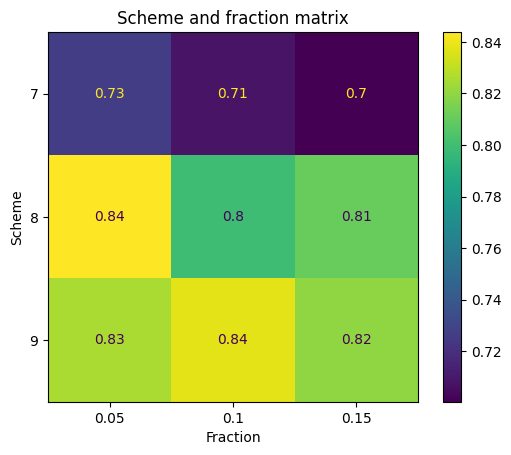

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=accuracy_vs_scheme_vs_fraction)
disp.plot()
disp.ax_.set_title("Scheme and fraction matrix")
disp.ax_.set_xlabel('Fraction')
disp.ax_.set_ylabel('Scheme')
tick_marks = np.arange(len(fractions))
plt.xticks(tick_marks, fractions)
plt.yticks(tick_marks, schemes)




In [ ]:
X, y, X_train, X_test, y_train, y_test,  X_val, y_val = get_X_y(df)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [ ]:
classes = print_classes(df)

In [ ]:
input_size = 1024
num_classes = len(classes)
batch_size = 512
epochs = 200

model_NN = Sequential([
    Dense(input_size, input_dim=input_size, activation='relu'),
    Dense(2*input_size, activation='relu'),
   # Dropout(0.1),
    #Dense(2*input_size, activation='relu'),
    #Dropout(0.2),
    #Dense(2*input_size, activation='relu'),
    # Dense(2*input_size, activation='relu'),
    # Dropout(0.2),
    # Dense(2*input_size, activation='relu'),
    # Dense(2*input_size, activation='relu'),
   #  Dropout(0.2),
     #Dense(2*input_size, activation='relu'),
     Dense(4*input_size, activation='relu'),
     Dropout(0.2),
    Dense(num_classes, activation='softmax')
  ])

model_NN.compile(loss='categorical_crossentropy', optimizer='Adam', metrics='accuracy')
#callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
history = model_NN.fit(X_train, y_train, #callbacks=[callback],
          batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(X_val, y_val))

In [ ]:
get_confusion_matrix(model_NN, X_test, y_test, 'neural_network', 'all', classes)

(400, 1024)
3/3 [==============================] - 0s 4ms/step
(400, 1024)
3/3 [==============================] - 0s 5ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

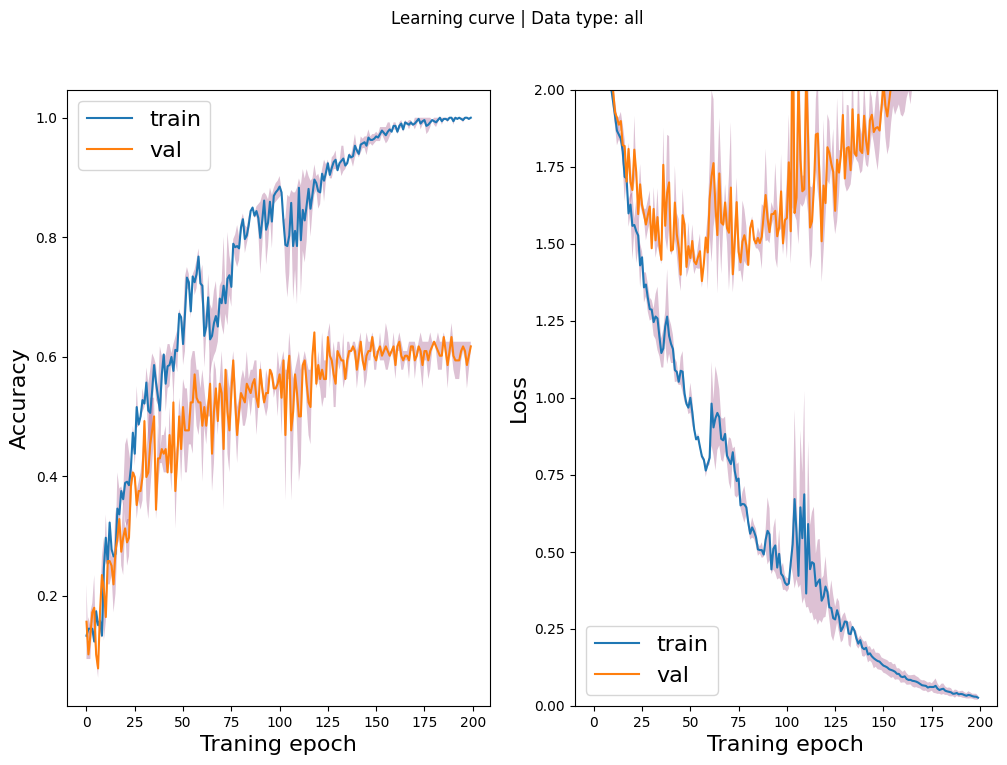

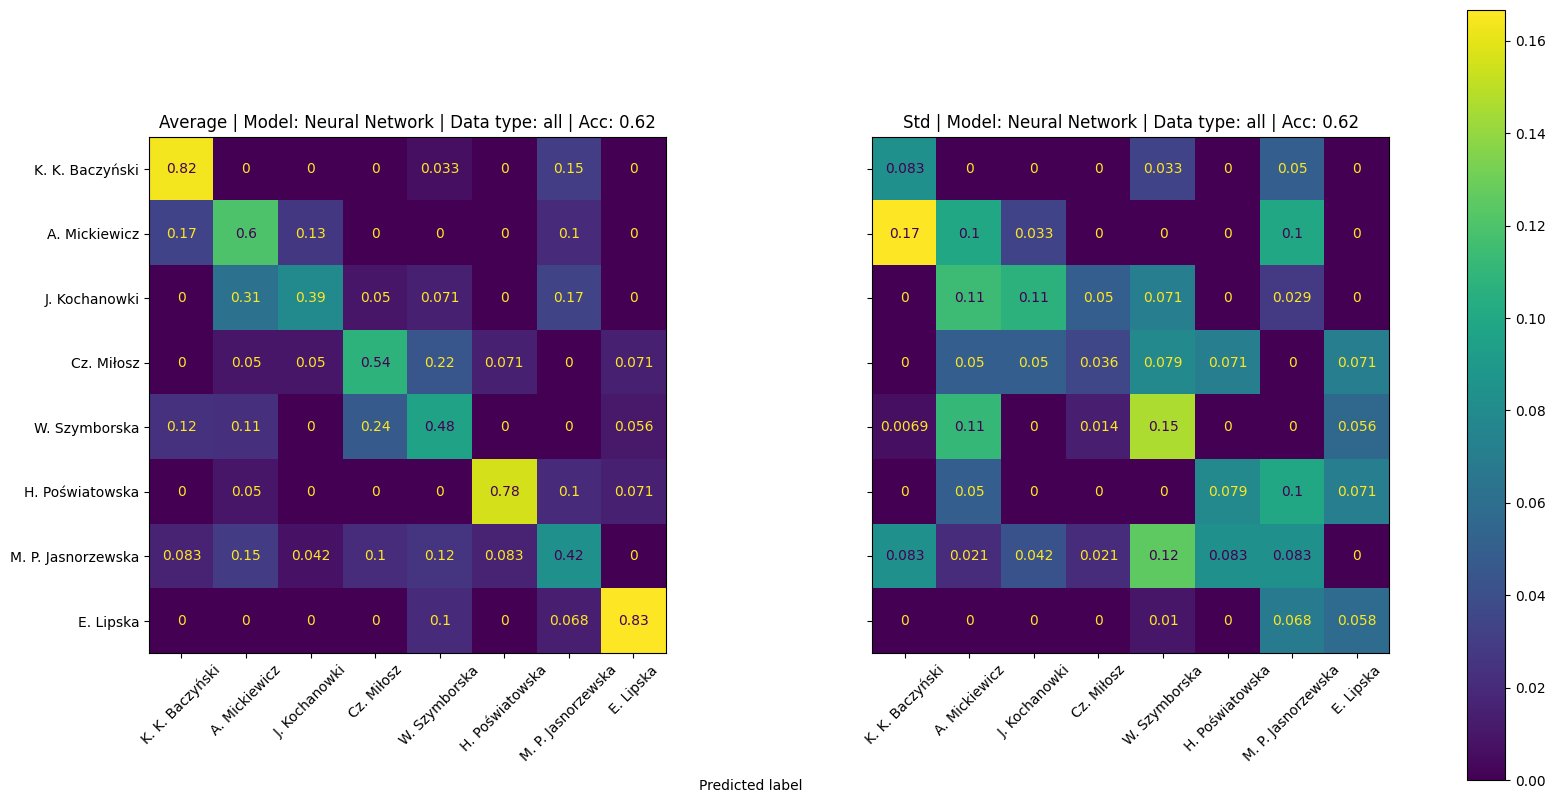

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.625

<Figure size 1000x500 with 0 Axes>

In [ ]:
make_experiment(df, 'all', '2')

In [ ]:
val_loss_mean = np.mean(val_loss_realizations, axis=1)
train_loss_mean = np.mean(train_loss_realizations, axis=1)
val_acc_mean = np.mean(val_acc_realizations, axis=1)
train_acc_mean = np.mean(train_acc_realizations, axis=1)

val_loss_std = np.std(val_loss_realizations, axis=1)
train_loss_std = np.std(train_loss_realizations, axis=1)
val_acc_std = np.std(val_acc_realizations, axis=1)
train_acc_std = np.std(train_acc_realizations, axis=1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

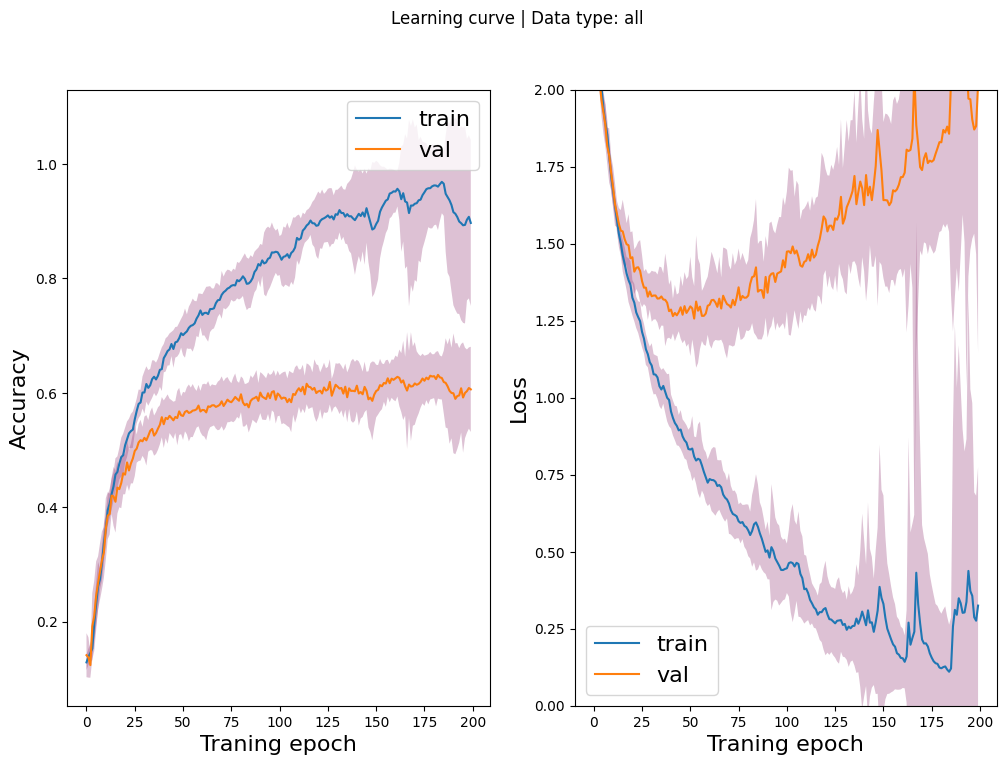

In [ ]:
fontsize = 16
data_type = "all"
epoch_vec = np.arange(0,epochs)
fig, ax = plt.subplots(1,2,figsize = (12, 8))
clrs = sns.color_palette("flare")
ax[1].set_ylim([0,2])
ax[1].plot(epoch_vec, train_loss_mean, label = "train")
ax[1].fill_between(epoch_vec, train_loss_mean - train_loss_std, train_loss_mean + train_loss_std, alpha = 0.3, facecolor=clrs[4] )
ax[1].plot(val_loss_mean,  label = "val")
ax[1].fill_between(epoch_vec, val_loss_mean - val_loss_std, val_loss_mean + val_loss_std, alpha = 0.3, facecolor=clrs[4] )

ax[0].plot(epoch_vec, train_acc_mean,  label = "train")
ax[0].fill_between(epoch_vec, train_acc_mean - train_acc_std, train_acc_mean + train_acc_std, alpha = 0.3, facecolor=clrs[4])
ax[0].plot(val_acc_mean,  label = "val")
ax[0].fill_between(epoch_vec, val_acc_mean - val_acc_std, val_acc_mean + val_acc_std, alpha = 0.3, facecolor=clrs[4] )


ax[1].set_xlabel("Traning epoch", fontsize=fontsize)
ax[1].set_ylabel("Loss", fontsize=fontsize)
ax[0].set_xlabel("Traning epoch", fontsize=fontsize)
ax[0].set_ylabel("Accuracy", fontsize=fontsize)

ax[1].legend( fontsize = fontsize)
ax[0].legend( fontsize = fontsize)
fig.suptitle('Learning curve | Data type: {}'.format(data_type))

fig.savefig('/content/figs/avgr_learning_curve_{}_remove_cut_3_remove.png'.format(data_type))
files.download('/content/figs/avgr_learning_curve_{}_remove_cut_3_remove.png'.format(data_type))

In [ ]:
CM_avrg = np.zeros((n_classes,n_classes))
CM_std = np.zeros((n_classes,n_classes))
score_avrg = np.mean(scores)

for i in range(0,n_classes):
  for j in range(0,n_classes):
    CM_avrg[i,j] = np.mean(CM[i,j,:])
    CM_std[i,j] = np.std(CM[i,j,:])

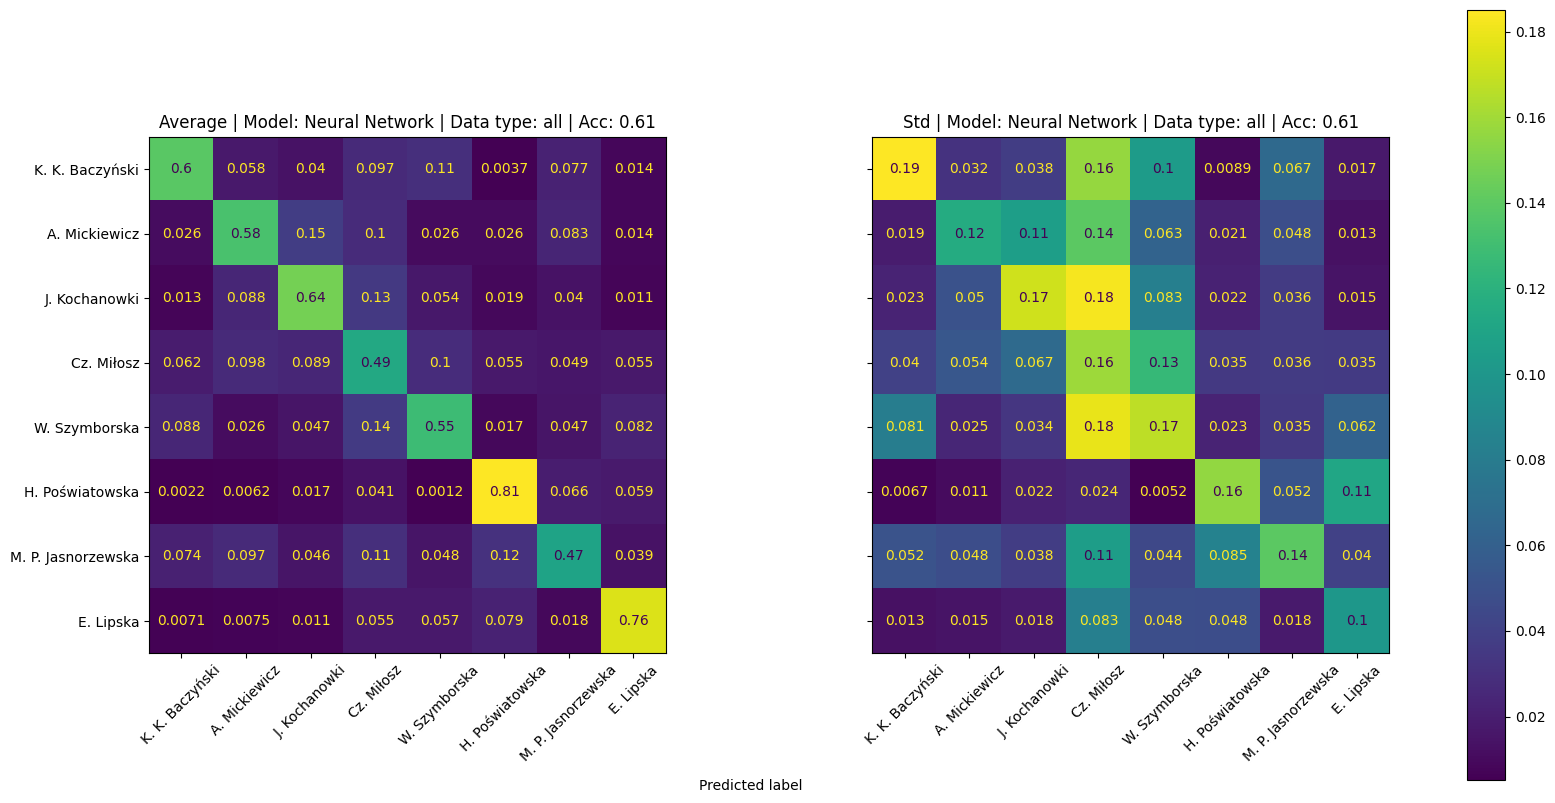

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1000x500 with 0 Axes>

In [ ]:
classes = print_classes(df)
cls = []
for k in classes.keys():
  cls.append(k)

tick_marks = np.arange(4)
cms = {"Average": CM_avrg, "Std": CM_std}


fig, axes = plt.subplots(1, 2, figsize=(20,10), sharey='row')

for i, (key, cm) in enumerate(cms.items()):

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls)
  disp.plot(ax=axes[i], xticks_rotation=45)
  disp.ax_.set_title("{} | Model: Neural Network | Data type: {} | Acc: {}".format(key, data_type, round(score_avrg,2)))
  disp.im_.colorbar.remove()
  disp.ax_.set_xlabel('')
  disp.ax_.set_ylabel('')


fig.text(0.40, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)

fig.colorbar(disp.im_, ax=axes)
plt.show()

plt.gcf().set_size_inches(10, 5)
fig.savefig('/content/figs/avrg_neural_network_{}_remove_cut_3_remove.png'.format(data_type), dpi=200)
files.download('/content/figs/avrg_neural_network_{}_remove_cut_3_remove.png'.format(data_type))

3/3 [==============================] - 0s 5ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

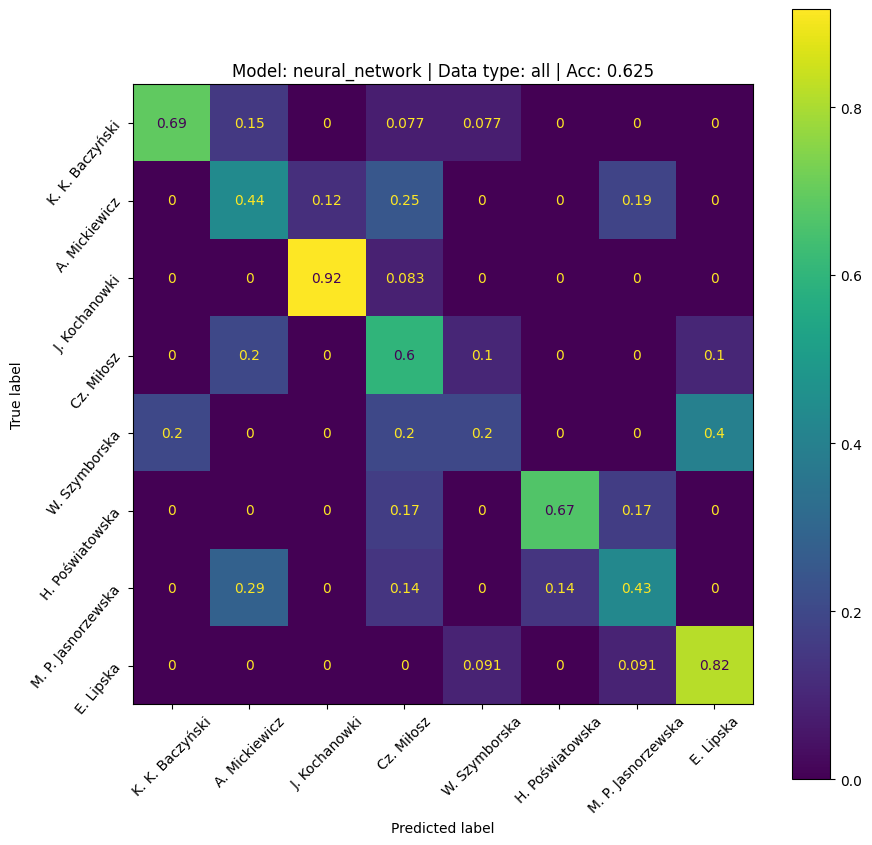

In [ ]:
scores, cm = get_confusion_matrix(model_NN, X_test, y_test, 'neural_network', 'all', classes)

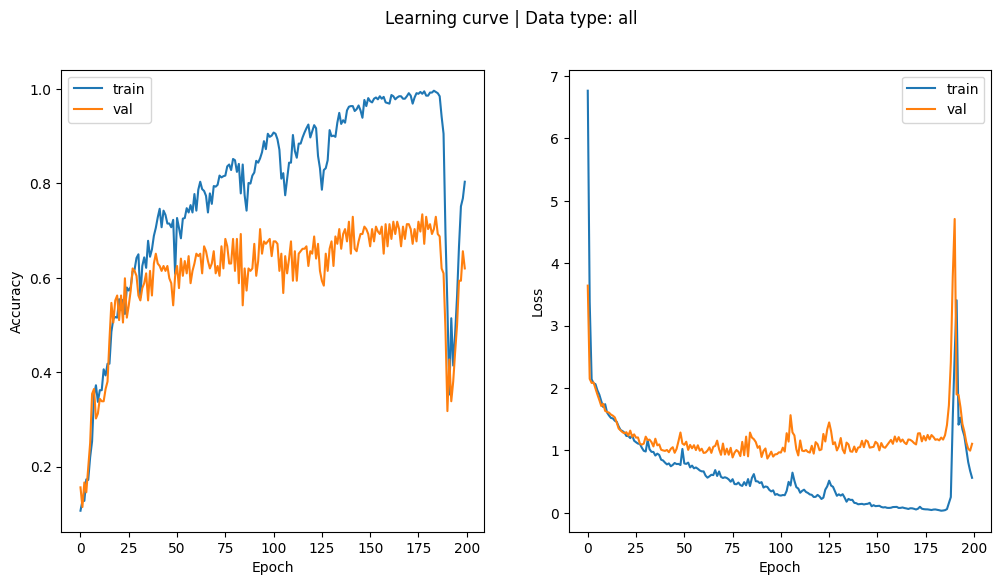

In [ ]:
draw_learning_curve(history, 'all')